# Hands-on: IC Resonant Circuit

In this hands-on, we measure RF components such as a phase shifter and an 3dB hybrid. Then, combining these components, we build a tunable power splitter and finally a resonant ring circuit. A resonant ring can recirculate the power which is not dissipated (coupled to the plasma) by a Traveling Wave Array (TWA) antenna.

In [1]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import skrf as rf

In [15]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [3]:
rf.stylely()  # figure aspect

## 3 dB Hybrid 

A bi-directional coupler has the following schematic:

<img src="directional_coupler_schematic.png" width="300"/>

If the power is evenly splitted from the input #1 to the outputs #2 and #3, then it is said to an hybrid coupler.

In [4]:
hybrid = rf.Network('IC_Resonant_Ring/narda_hybrid.s4p')
hybrid.frequency.unit = 'GHz'

The device almost equally split the power by 2 (-3dB) while the phase difference between port 2 and 3 is 90°: 
$$\arg S_{21} - \arg S_{31} = \pi/2$$

<IPython.core.display.Javascript object>


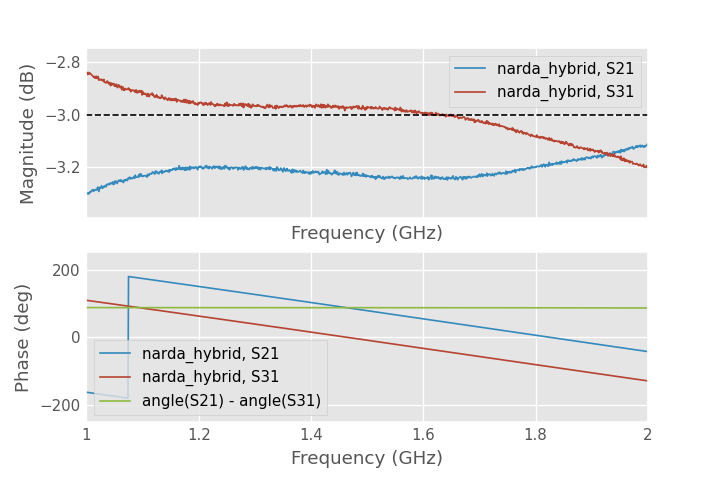

In [5]:
fig, axes = plt.subplots(2, 1, sharex=True)
hybrid.plot_s_db(m=1, n=0, ax=axes[0])  # S21 through
hybrid.plot_s_db(m=2, n=0, ax=axes[0])  # S31 coupled
axes[0].axhline(-3, ls='--', color='k')

hybrid.plot_s_deg(m=1, n=0, ax=axes[1])  # S21
hybrid.plot_s_deg(m=2, n=0, ax=axes[1])  # S31
(hybrid.s21/hybrid.s31).plot_s_deg(ax=axes[1], label='angle(S21) - angle(S31)')  # phase difference

The hybrid is not perfect: reflection and isolation are not zero:

<IPython.core.display.Javascript object>


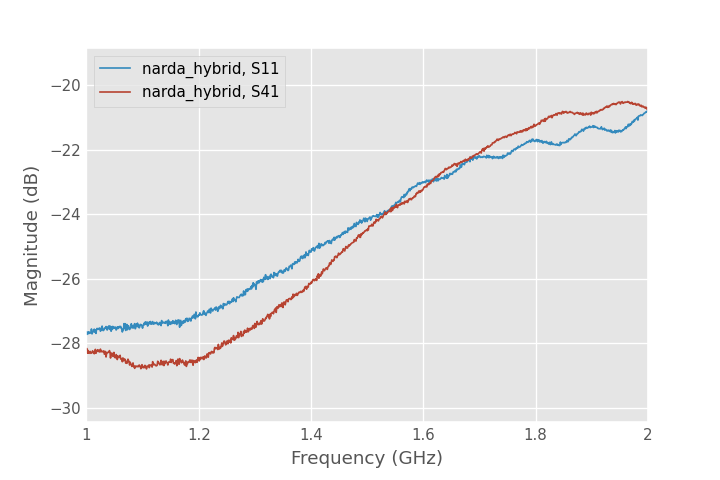

In [6]:
fig, ax = plt.subplots()
hybrid.plot_s_db(m=0, n=0, ax=ax)  # S11 reflection
hybrid.plot_s_db(m=3, n=0, ax=ax)  # S41 isolation

An important feature of hybrid couplers is that if ports 1 and 4 are fed with a signal of same amplitude and phase, the resulting signals on port 2 and 3 will also be of same amplitude and phase:

In [26]:
b = hybrid.s @ np.r_[1, 0, 0, 1]

<IPython.core.display.Javascript object>


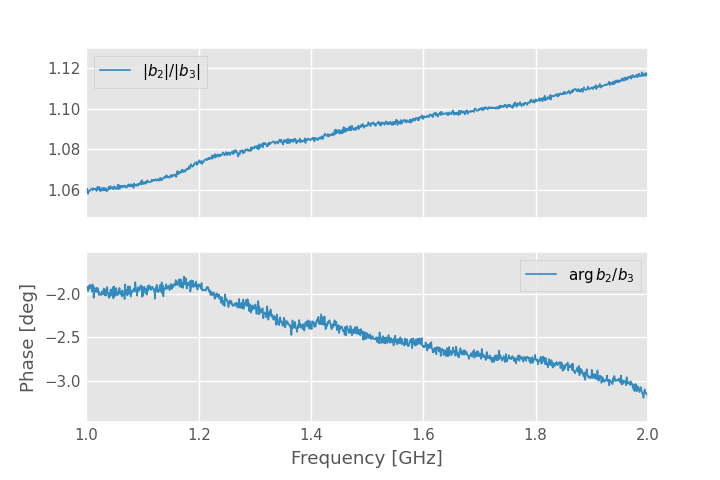

Text(0.5, 0, 'Frequency [GHz]')

In [27]:
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(hybrid.frequency.f_scaled, np.abs(b[:,1])/np.abs(b[:,2]))
axes[0].legend((r'$|b_2|/|b_3|$',))
axes[1].plot(hybrid.frequency.f_scaled, rf.angle(b[:,1]/b[:,2], deg=True))
axes[1].legend((r'$\arg b_2/b_3$',))
axes[1].set_ylabel('Phase [deg]')
axes[1].set_xlabel('Frequency [GHz]')

## Directional Couplers

Two kinds of directional couplers are given during this hands-on: a 10dB and a 30dB couplers. 

<IPython.core.display.Javascript object>


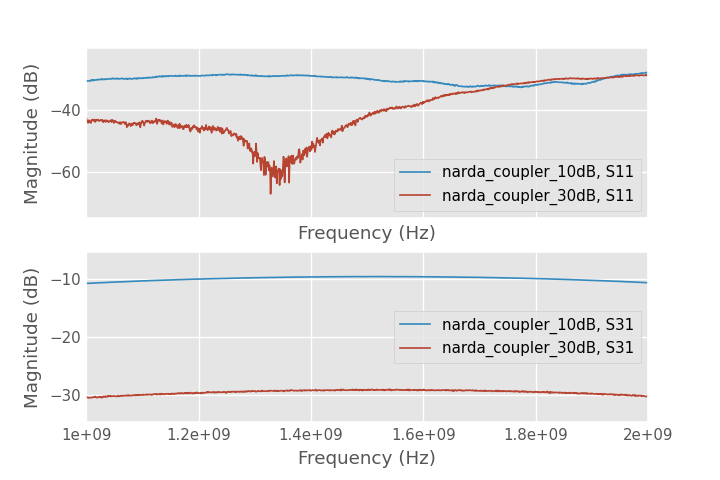

In [28]:
coupler10dB = rf.Network('IC_Resonant_Ring/narda_coupler_10dB.s3p')
coupler30dB = rf.Network('IC_Resonant_Ring/narda_coupler_30dB.s3p')

fig, axes = plt.subplots(2, 1, sharex=True)
coupler10dB.plot_s_db(m=0, n=0, ax=axes[0])  # reflection
coupler30dB.plot_s_db(m=0, n=0, ax=axes[0])  # reflection

coupler10dB.plot_s_db(m=2, n=0, ax=axes[1])  # coupling port
coupler30dB.plot_s_db(m=2, n=0, ax=axes[1])  # coupling port

## Phase Shifter

The phase shifter S-parameters obviously depend on the phase delay knob. Below we have measured the S-parameters of a phase shifter for every 10°/GHz from 0°/GHz to 180°/GHz. We load these data as a NetworkSet and we use the interpolate method to create a phase shifter Network that can be used for any phase shift.  

In [29]:
phase_shifter_ns = rf.NetworkSet.from_dir('IC_Resonant_Ring/narda_phase_shifter/')

def phase_shifter(phi_per_GHz):
    """
    phi in deg
    """
    phis_per_GHz = np.linspace(0, 180, 19)
    ntwk = phase_shifter_ns.interpolate_from_network(phis_per_GHz, phi_per_GHz)
    ntwk.name = f'Narda Phase Shifter {phi_per_GHz}/GHz'
    return ntwk

Here are some angle vs f for various value of the knob:

<IPython.core.display.Javascript object>


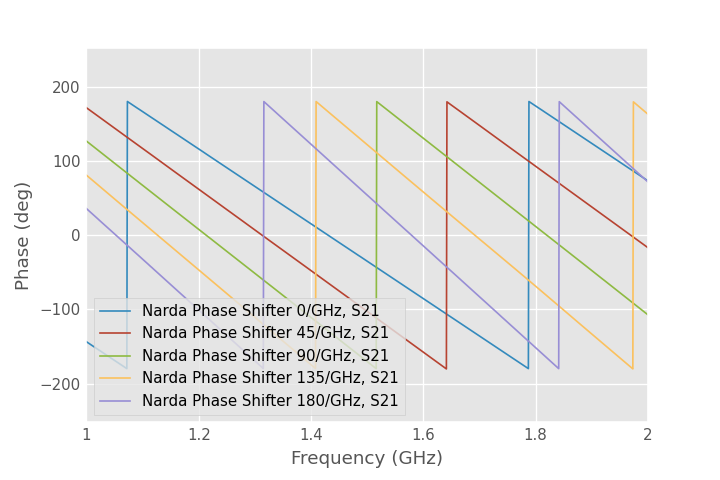

In [30]:
fig, ax = plt.subplots()
phase_shifter(0).plot_s_deg(m=1, n=0, ax=ax)
phase_shifter(45).plot_s_deg(m=1, n=0, ax=ax)
phase_shifter(90).plot_s_deg(m=1, n=0, ax=ax)
phase_shifter(135).plot_s_deg(m=1, n=0, ax=ax)
phase_shifter(180).plot_s_deg(m=1, n=0, ax=ax)

We can also trace the phase shift at a given frequency vs the indictator button value:

<IPython.core.display.Javascript object>


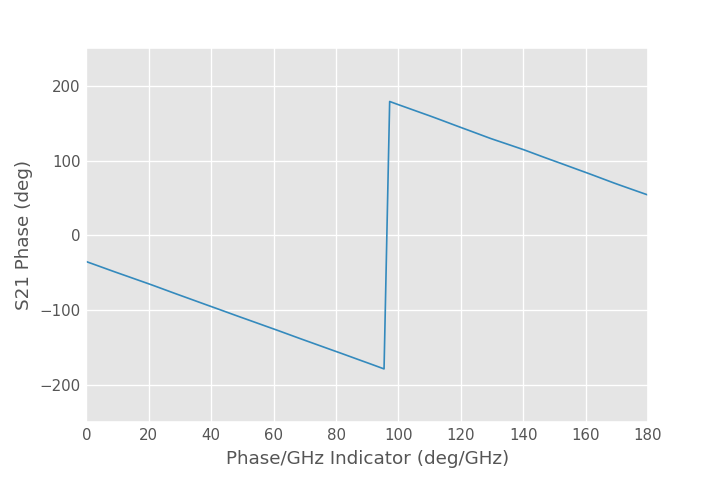

Text(0, 0.5, 'S21 Phase (deg)')

In [56]:
f0 = '1.5GHz'
phis = []
phis_per_GHz = np.linspace(0, 180, 101)

for phi_per_GHz in phis_per_GHz:
    phis.append(phase_shifter(phi_per_GHz)[f0].s_deg[:,1,0])
phis = np.array(phis).squeeze()

fig, ax = plt.subplots()
ax.plot(phis_per_GHz, phis)
ax.set_xlabel('Phase/GHz Indicator (deg/GHz)')
ax.set_ylabel('S21 Phase (deg)')

## Variable Coupler

Here we construct the variable coupler as we do in reality using the various devices of the hands-on:

In [59]:
cable = rf.Network('IC_Resonant_Ring/cable_RG214_1.s2p')
cable.name = 'cable'

def variable_coupler(phi_per_GHz):
    ports = [rf.Circuit.Port(frequency=hybrid.frequency, name=f'port_{n}') for n in [1,2,3,4]]

    hybrid1 = hybrid.copy()
    hybrid1.name = 'hybrid1'
    hybrid2 = hybrid.copy()
    hybrid2.name = 'hybrid2'

    ps = phase_shifter(phi_per_GHz=phi_per_GHz)

    cnx = [
        [(ports[0], 0), (hybrid1, 0)],
        [(ports[3], 0), (hybrid1, 3)],
        [(ports[1], 0), (hybrid2, 1)],
        [(ports[2], 0), (hybrid2, 2)],    
        [(hybrid1, 1), (cable, 0)], [(cable, 1), (hybrid2,0)],
        [(hybrid1, 2), (ps,0)], [(ps, 1), (hybrid2,3)],
    ]
    return rf.Circuit(cnx).network

<IPython.core.display.Javascript object>


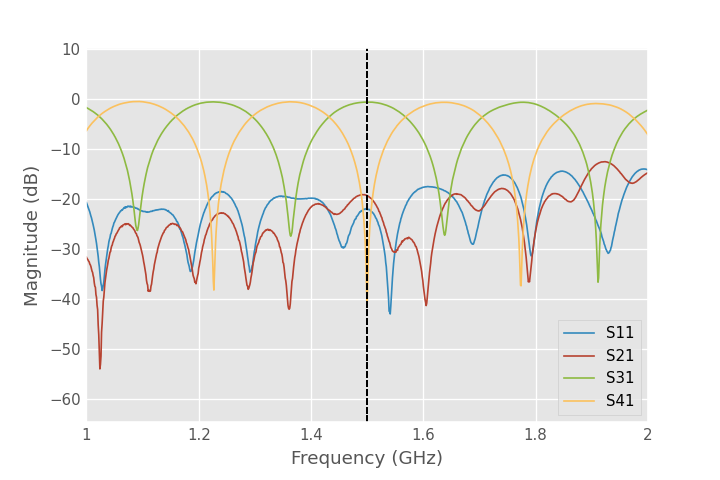

interactive(children=(IntSlider(value=0, description='phi_per_GHz', max=180), Output()), _dom_classes=('widget…

In [63]:
fig, ax = plt.subplots()

@interact(phi_per_GHz=widgets.IntSlider(min=0, max=180, step=1))
def plot_tunable_coupler(phi_per_GHz=0):
    ax.clear()
    variable_coupler(phi_per_GHz).plot_s_db(m=0, n=0, ax=ax)
    variable_coupler(phi_per_GHz).plot_s_db(m=1, n=0, ax=ax)
    variable_coupler(phi_per_GHz).plot_s_db(m=2, n=0, ax=ax)
    variable_coupler(phi_per_GHz).plot_s_db(m=3, n=0, ax=ax)
    ax.axvline(1.5e9, color='k', ls='--')

An important parameter of the variable coupler is the phase difference between the branch prior the second hybrid. To check these, let's build a circuit with couplers located at these places:

In [80]:
coupler_10dB = rf.Network('IC_Resonant_Ring/narda_coupler_10dB.s3p')

def variable_coupler(phi_per_GHz):
    ports = [rf.Circuit.Port(frequency=hybrid.frequency, name=f'port_{n}') for n in [1,2,3,4,5,6]]

    hybrid1 = hybrid.copy()
    hybrid1.name = 'hybrid1'
    hybrid2 = hybrid.copy()
    hybrid2.name = 'hybrid2'
    
    coupler1 = coupler_10dB.copy()
    coupler1.name = 'coupler1'
    coupler2 = coupler_10dB.copy()
    coupler2.name = 'coupler2'

    ps = phase_shifter(phi_per_GHz=phi_per_GHz)

    cnx = [
        [(ports[0], 0), (hybrid1, 0)],
        [(ports[3], 0), (hybrid1, 3)],
        [(ports[1], 0), (hybrid2, 1)],
        [(ports[2], 0), (hybrid2, 2)],    
        [(hybrid1, 1), (cable, 0)], [(cable, 1), (coupler1, 0)], [(coupler1, 1), (hybrid2,0)],
        [(hybrid1, 2), (ps,0)], [(ps, 1), (coupler2, 0)], [(coupler2,1), (hybrid2,3)],
        [(ports[4],0), (coupler1,2)], 
        [(ports[5],0), (coupler2,2)]
    ]
    return rf.Circuit(cnx).network

<IPython.core.display.Javascript object>


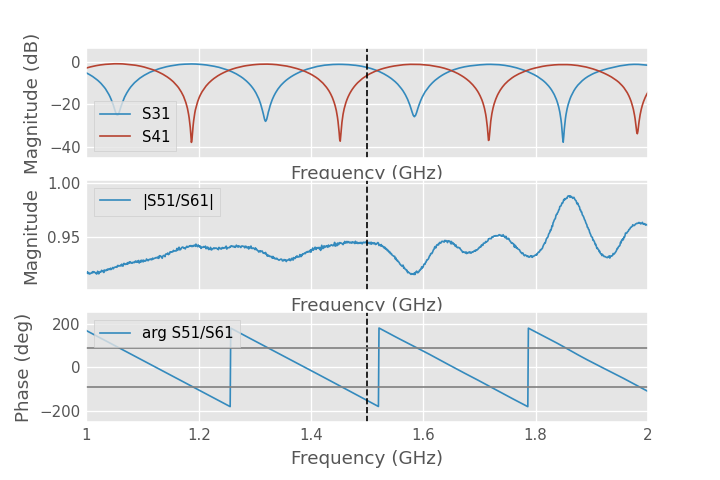

interactive(children=(IntSlider(value=0, description='phi_per_GHz', max=180), Output()), _dom_classes=('widget…

In [84]:
fig, axes = plt.subplots(3, 1, sharex=True)

@interact(phi_per_GHz=widgets.IntSlider(min=0, max=180, step=1))
def plot_tunable_coupler(phi_per_GHz=0):
    vc = variable_coupler(phi_per_GHz)
    [ax.clear() for ax in axes]
    vc.plot_s_db(m=2, n=0, ax=axes[0])
    vc.plot_s_db(m=3, n=0, ax=axes[0])
    (vc.s51/vc.s61).plot_s_mag(ax=axes[1], label='|S51/S61|')
    (vc.s51/vc.s61).plot_s_deg(ax=axes[2], label='arg S51/S61')
    [ax.axvline(1.5e9, color='k', ls='--') for ax in axes]
    axes[-1].axhline(+90, color='gray')
    axes[-1].axhline(-90, color='gray')   

## Resonant Ring

In [85]:
attenuator_set = rf.NetworkSet.from_dir('IC_Resonant_Ring/attenuator/')

def attenuator(att):
    cal = np.linspace(0, 10, 11)
    return attenuator_set.interpolate_from_network(cal, att)

<IPython.core.display.Javascript object>


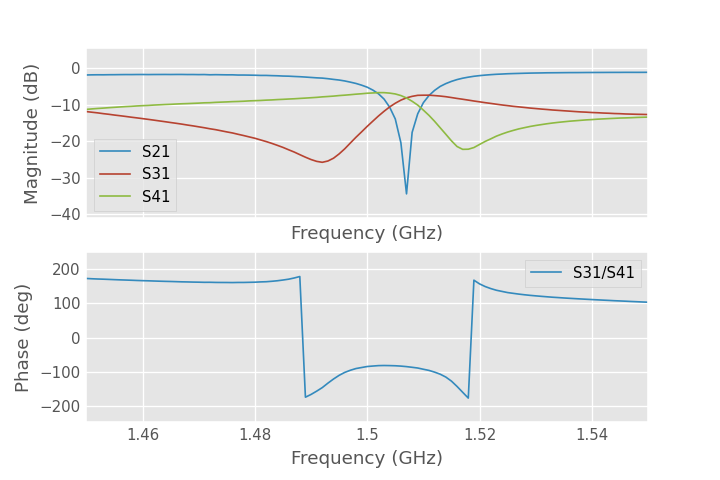

interactive(children=(IntSlider(value=96, description='phi', max=180), IntSlider(value=49, description='theta'…

In [86]:
fig, ax = plt.subplots(2, 1, sharex=True)
@interact(phi=widgets.IntSlider(min=0, max=180, step=1, value=96),
         theta=widgets.IntSlider(min=0, max=180, step=1, value=49),
         calibre_att=widgets.IntSlider(min=0, max=10, step=1))
def variable_coupler(phi, theta, calibre_att):

    cable = rf.Network('IC_Resonant_Ring/cable_RG214_1.s2p')
    cable.name = 'cable'

    ports = [rf.Circuit.Port(frequency=hybrid.frequency, name=f'port_{n}') for n in [1,2,3,4]]

    hybrid1 = hybrid.copy()
    hybrid1.name = 'hybrid1'
    hybrid2 = hybrid.copy()
    hybrid2.name = 'hybrid2'
    coupler1 = coupler_10dB.copy()
    coupler1.name = 'coupler1'
    coupler2 = coupler_10dB.copy()
    coupler2.name = 'coupler2'
    
    ps_theta = phase_shifter(phi_per_GHz=theta)
    ps_phi = phase_shifter(phi_per_GHz=phi)
    atte = attenuator(calibre_att)
    
    cnx = [
        [(ports[0], 0), (hybrid1, 3)],
        [(ports[1], 0), (hybrid2, 2)],    
        [(hybrid1, 1), (cable, 0)], [(cable, 1), (coupler1, 0)], [(coupler1, 1), (hybrid2,0)],
        [(hybrid1, 2), (ps_phi,0)], [(ps_phi, 1), (coupler2, 0)], [(coupler2, 1), (hybrid2,3)],
        [(atte, 0), (hybrid2, 1)],
        [(atte, 1), (ps_theta, 0)],
        [(ps_theta, 1), (hybrid1, 0)],
        [(coupler1, 2), (ports[2], 0)],
        [(coupler2, 2), (ports[3], 0)]
    ]
    ntwk = rf.Circuit(cnx).network['1.45-1.55GHz']

    [a.clear() for a in ax]
    ntwk.plot_s_db(m=1, n=0, ax=ax[0])
    ntwk.plot_s_db(m=2, n=0, ax=ax[0])
    ntwk.plot_s_db(m=3, n=0, ax=ax[0])

    (ntwk.s31/ntwk.s41).plot_s_deg(ax=ax[1], label='S31/S41')
    

## CSS Styling

In [87]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()